## Clustering

Before implementing a complex Graph Neural Network (GNN) for unsupervised clustering, I want to clarify the problem, as the current research proposal seems vague. This step will help me understand our current leads and establish solid baselines. I aim for this research to be reproducible and fully open-sourced, facilitating easy use of our codebase and baselines by other researchers trying different methods.

### Settings

1. **Chunk Definition:**
   - A Chunk is a of 100 words.
   - For a book with 160 words, it will be split into: 1 chunk of 100 words each, plus 1 sentence of 60 words.

2. **Data Source:**
   - Using non-biblical Hebrew Qumran scrolls (90 books).

3. **Composition Labels:**
   - A composition is a label consisting of several books together.
   - For example, books 11Q20 and 11Q19 are from the Temple Scroll composition.
   - We currently have 25 unique compositions over 98 books.

4. **Methodology:**
   - **Step 1:** Convert each book into sentences.
   - **Step 2:** Vectorize the text (using n-grams, TF-IDF, Word2Vec, BERT, etc.).

Now we will tackle the following problems:
1. Unsupervised clustering (scroll level) - using Hierarchical Clustering when the objective is the Dasgupta score, scipy.cluster.hierarchy.cophene [ref](https://arxiv.org/pdf/1905.05667), max-dist (ours), 
2. Unsupervised classification (sectarian vs non-sectarian) - using K-means when the objective is adjusted-rand-index, jaccard, nmi, v-measure. **try to answer the question: is the temple scroll is sectarian or not**.
3. Supervised multi-class classification (composition level) - accuracy, precision, recall.
4. Supervised binary classification (sectarian/non sectarian) - accuracy, precision, recall.

under the line:
1. Clustering of Serech Hayachad (חוקים, שירה וכו)
2. Clustering for CD.
3. Check if there different מזמורים in Hodayot.
4. Is Temple Scroll is sectarian?
5. Compare Instruction and Mysteries.
6. Compare pesharim and catena florilegium.


In [2]:

import pandas as pd

from config import BASE_DIR
from notebooks.clustering_main import run_clustering_cv
from notebooks.constants import BERT_MODELS
from notebooks.notebooks_utils import set_seed_globaly
from notebooks.plots_utils import create_dasgupta_score_plot
from notebooks.plots_utils import create_lca_metric_boxplot

RERUN = False

In [3]:


clustering_label = "composition"
CHUNK_SIZE = 100
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 25 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   book                                                                1365 non-null   object 
 1   sentence_path                                                       1365 non-null   object 
 2   text_lex                                                            1362 non-null   object 
 3   text                                                                1365 non-null   object 
 4   n_words_lex                                                         1365 non-null   int64  
 5   n_words                                                             1365 non-null   int64  
 6   construct to absolute nouns ratio                                   1365 non-null   float64
 7   construct nouns

In [4]:
df["book"].unique().shape

(90,)

Our dataset contains chunks of 100 words (using scrolls that have more than 300 words and written in hebrew).
I will use 4 different vectorizers: Starr, trigrams, BERT, tf-idf. When our metric for clustering will be the dgapusta score.

In [ ]:
import pickle
from notebooks.features import vectorize_text
import os

set_seed_globaly()
processed_vectorizers = {}
processed_vectorizers_path = f"{BASE_DIR}/notebooks/data/processed_vectorizers.pkl"
if os.path.exists(processed_vectorizers_path):
    with open(processed_vectorizers_path, 'rb') as f:
        processed_vectorizers = pickle.load(f)
        print(f"loaded the embeddings:{[list(processed_vectorizers.keys())]}")
else:
    for vectorizer_type in BERT_MODELS + ['tfidf', 'trigram', 'starr']:
        if vectorizer_type in processed_vectorizers.keys():
            X = processed_vectorizers.get(vectorizer_type)
        else:
            X = vectorize_text(df, "text", vectorizer_type)
            processed_vectorizers[vectorizer_type] = X

    with open(processed_vectorizers_path, 'wb') as f:
        pickle.dump(processed_vectorizers, f)

idx_to_remove_composition = df['composition'].isna()
idx_to_remove_sectarian = (df['section'].isna()) | (df['section'] == "unknown")
processed_vectorizers_comp, processed_vectorizers_sec = {}, {}

for vec_type, vectorizer_mat in processed_vectorizers.items():
    processed_vectorizers_comp[vec_type] = vectorizer_mat[~idx_to_remove_composition]
    processed_vectorizers_sec[vec_type] = vectorizer_mat[~idx_to_remove_sectarian]

## Hirerchial clustering baseline with different vectorizers

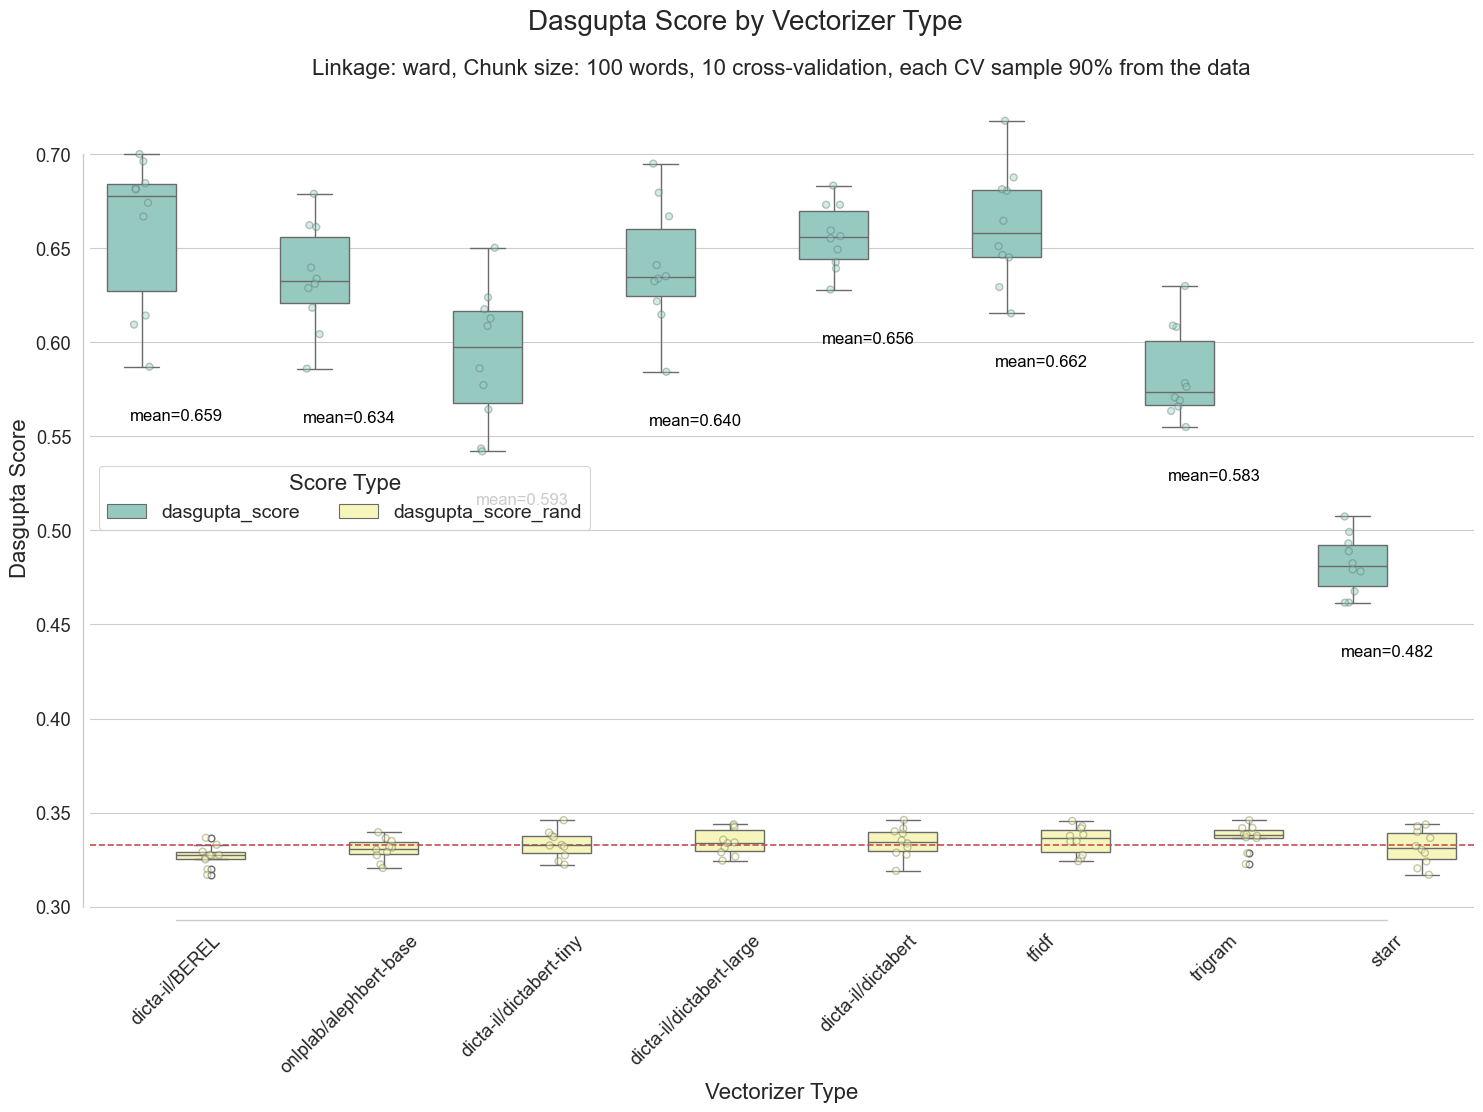

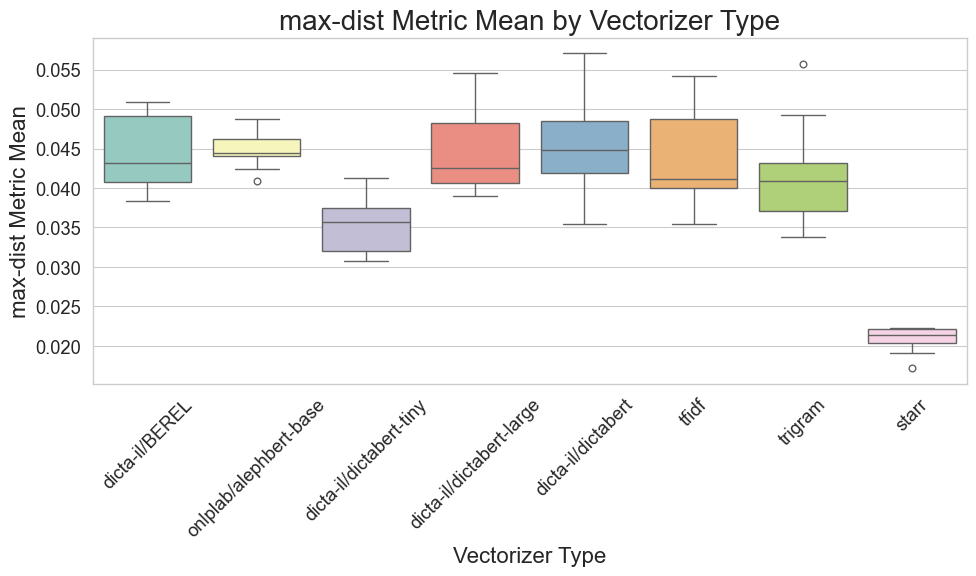

In [5]:


set_seed_globaly()

PATH_HC = f"{BASE_DIR}/notebooks/reports/baselines/hc_baseline_dasgupta"
NUM_CVS = 10
FRAC = 0.9
CONTEXT_SIMILIARITY_WINDOW = 3
vectorizers = BERT_MODELS + ['tfidf', 'trigram', 'starr']
linkage_method = "ward"
file_name = 'dasgupta_scores_window_{}_composition_frac_{}_linkage_{}'.format(CONTEXT_SIMILIARITY_WINDOW,
                                                                              str(FRAC).replace(".", "_"),
                                      linkage_method)
if RERUN:
    scores_df = run_clustering_cv(processed_vectorizers, df, FRAC, NUM_CVS, CONTEXT_SIMILIARITY_WINDOW, vectorizers,
                                  linkage_method)
    scores_df.to_csv(f"{PATH_HC}/{file_name}.csv", index=False)
else:
    scores_df = pd.read_csv(f"{PATH_HC}/{file_name}.csv")

create_dasgupta_score_plot(scores_df, CHUNK_SIZE, NUM_CVS, FRAC, linkage_method, f"{PATH_HC}/{file_name}",
                           show_p_val=False,
                           p_val_random_test=False, show_mean_scores=True)

create_lca_metric_boxplot(scores_df, f"{PATH_HC}/{file_name}_max_dist")

In [5]:
from notebooks.features import vectorize_text

set_seed_globaly()
BERT_MODELS = ['dicta-il/BEREL',
               'onlplab/alephbert-base',
               'dicta-il/dictabert']
processed_vectorizers = {}
for vectorizer_type in BERT_MODELS + ['tfidf', 'trigram', 'starr']:
    if vectorizer_type in processed_vectorizers.keys():
        X = processed_vectorizers.get(vectorizer_type)
    else:
        X = vectorize_text(df, "text", vectorizer_type)
        processed_vectorizers[vectorizer_type] = X

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at dicta-il/BEREL and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/1365 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

bert:   0%|          | 0/1365 [00:00<?, ?it/s]

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/1365 [00:00<?, ?it/s]

In [6]:
idx_to_remove_composition = df['composition'].isna()
idx_to_remove_sectarian = (df['section'].isna()) | (df['section'] == "unknown")
processed_vectorizers_comp, processed_vectorizers_sec = {}, {}

for vec_type, vectorizer_mat in processed_vectorizers.items():
    processed_vectorizers_comp[vec_type] = vectorizer_mat[~idx_to_remove_composition]
    processed_vectorizers_sec[vec_type] = vectorizer_mat[~idx_to_remove_sectarian]

In [7]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import plotly.express as px
from warnings import simplefilter
from scipy import sparse as sp
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, jaccard_score
from sklearn.preprocessing import LabelEncoder


def get_clusterer(clustering_algo, n_clusters):
    # Apply the selected clustering algorithm
    if clustering_algo == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    elif clustering_algo == 'agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    elif clustering_algo == 'dbscan':
        clusterer = DBSCAN(eps=6, min_samples=5)
    else:
        raise ValueError("Unsupported clustering algorithm. Choose from 'kmeans', 'agglomerative', or 'dbscan'.")
    return clusterer


def compute_metrics(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo="kmeans", n_clusters=2):
    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()
    clusterer = get_clusterer(clustering_algo, n_clusters)

    df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(str)  # Convert labels to strings

    # Compute evaluation metrics
    le = LabelEncoder()
    le.fit(df[label_column])
    true_labels_encode = le.transform(df[label_column])
    predicted_labels = clusterer.labels_

    ari = adjusted_rand_score(true_labels_encode, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels_encode, predicted_labels)
    fmi = fowlkes_mallows_score(true_labels_encode, predicted_labels)
    jaccard = jaccard_score(true_labels_encode, predicted_labels, average="weighted")

    metrics = {
        'vectorizer_type': vectorizer_type,
        'ari': ari,
        'nmi': nmi,
        'fmi': fmi,
        'jaccard': jaccard
    }

    return metrics


def generate_plots(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo='kmeans', n_clusters=2):
    simplefilter(action='ignore', category=FutureWarning)
    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()

    clusterer = get_clusterer(clustering_algo, n_clusters)
    df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(
        str)  # Convert labels to strings if needed

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(vectorizer_matrix)

    # Add t-SNE results to the dataframe
    df['tsne-2d-one'] = tsne_results[:, 0]
    df['tsne-2d-two'] = tsne_results[:, 1]

    # Create a facet plot to compare true and predicted labels
    df['label_type'] = 'Predicted'
    true_labels_df = df.copy()
    true_labels_df['predicted_cluster'] = true_labels_df[label_column]
    true_labels_df['label_type'] = 'True'
    combined_df = pd.concat([df, true_labels_df])

    facet_fig = px.scatter(
        combined_df, x='tsne-2d-one', y='tsne-2d-two',
        color='predicted_cluster', facet_col='label_type',
        hover_data={'book': True, label_column: True, "sentence_path": True},
        title=f"t-SNE visualization of clusters: Predicted vs. True ({vectorizer_type}, {clustering_algo})"
    )

    # Update the figure size
    facet_fig.update_layout(
        width=1000,  # Adjust the width as needed
        height=800  # Adjust the height as needed
    )

    facet_fig.update_traces(marker=dict(size=10),
                            selector=dict(mode='markers+text'))
    simplefilter(action='default', category=FutureWarning)
    return facet_fig


## Unsupervised clustering composition level

In [8]:

df_comp = df.dropna(subset="composition")
vectorizer_types = processed_vectorizers_comp.keys()
metrics_list = []

for vectorizer_type in vectorizer_types:
    metrics = compute_metrics(processed_vectorizers_comp, vectorizer_type, df_comp, "composition",
                              clustering_algo="agglomerative", n_clusters=df_comp["composition"].nunique())
    metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/unsupervised_clustering_composition_level"
metrics_df.to_csv(f"{PATH}/unsupervised_clustering_composition_level.csv", index=False)
metrics_df.sort_values(by=["ari", "jaccard"])



/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_92426/893876923.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(str)  # Convert labels to strings
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_92426/893876923.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(str)  # Convert labels to strings
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m

,vectorizer_type,ari,nmi,fmi,jaccard
5,starr,0.116485,0.310781,0.187350,0.026563
3,tfidf,0.180431,0.518312,0.286090,0.014342
4,trigram,0.219189,0.527181,0.293021,0.005530
0,dicta-il/BEREL,0.264646,0.528527,0.314998,0.005325
1,onlplab/alephbert-base,0.288869,0.538261,0.337811,0.080885
2,dicta-il/dictabert,0.304946,0.561540,0.353257,0.053973


In [9]:
from tqdm.notebook import tqdm
import plotly.io as pio

plots = []

for vectorizer_type in tqdm(vectorizer_types):
    facet_fig = generate_plots(processed_vectorizers_comp, vectorizer_type, df_comp, "composition",
                               clustering_algo="agglomerative", n_clusters=df_comp["composition"].nunique())
    plots.append((facet_fig))

with open(f"{PATH}/clustering_plots.html", "w") as f:
    for i, facet_fig in enumerate(plots):
        html_str = pio.to_html(facet_fig, full_html=False)
        f.write(html_str)
        f.write(f"<hr>Plot {i + 1}<hr>")  # Add a horizontal rule between plots for s


  0%|          | 0/6 [00:00<?, ?it/s]

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_92426/893876923.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_92426/893876923.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-one'] = tsne_results[:, 0]
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_92426/893876923.py:71: SettingWithCopyWarning: 
A value is trying to be set on a co

## Unsupervised clustering for sectarian/non sectarian

In [10]:
vectorizer_types = processed_vectorizers_sec.keys()
sec_df = df[df["section"] != "unknown"].dropna(subset=["section"])

metrics_list = []

for vectorizer_type in vectorizer_types:
    metrics = compute_metrics(processed_vectorizers_sec, vectorizer_type, sec_df, "section",
                              clustering_algo="agglomerative", n_clusters=sec_df["section"].nunique())
    metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/unsupervised_clustering_sectarian_level"
metrics_df.to_csv(f"{PATH}/unsupervised_clustering_sectarian_level.csv", index=False)
metrics_df.sort_values(by=["ari", "jaccard"])



,vectorizer_type,ari,nmi,fmi,jaccard
0,dicta-il/BEREL,-0.025277,0.002031,0.759421,0.167614
4,trigram,-0.001696,0.000027,0.657862,0.530422
2,dicta-il/dictabert,-0.001160,0.000003,0.702342,0.248860
1,onlplab/alephbert-base,0.011619,0.000357,0.842997,0.074639
3,tfidf,0.020846,0.016200,0.652962,0.518047
5,starr,0.027775,0.002186,0.866684,0.783905


In [11]:
from tqdm.notebook import tqdm

plots = []

for vectorizer_type in tqdm(vectorizer_types):
    facet_fig = generate_plots(processed_vectorizers_sec, vectorizer_type, sec_df, "section",
                               clustering_algo="agglomerative", n_clusters=sec_df["section"].nunique())
    plots.append((facet_fig))

with open(f"{PATH}/clustering_plots.html", "w") as f:
    for i, facet_fig in enumerate(plots):
        html_str = pio.to_html(facet_fig, full_html=False)
        f.write(html_str)
        f.write(f"<hr>Plot {i + 1}<hr>")  # Add a horizontal rule between plots for s


  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier


def compute_classification_metrics(model, processed_vectorizers, vectorizer_type, df, train_idx, test_idx,
                                   label_column):
    le = LabelEncoder()
    df['encoded_labels'] = le.fit_transform(df[label_column])

    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    X_train, y_train = vectorizer_matrix[train_idx], df.loc[train_idx, 'encoded_labels']
    X_test, y_test = vectorizer_matrix[test_idx], df.loc[test_idx, 'encoded_labels']
    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics = {
        'model': type(model).__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics


## Supervised classification for sectarian/non sectarian

In [13]:

# Define the models and vectorizers to be evaluated
models = [
    RandomForestClassifier(random_state=42),
    LogisticRegression(max_iter=200),
    SVC(),
    KNeighborsClassifier(),
    AdaBoostClassifier(random_state=42),
]
metrics_list = []
vectorizer_types = processed_vectorizers_sec.keys()

label_column = "section"
train_idx, test_idx = train_test_split(
    sec_df.reset_index().index, test_size=0.3, random_state=42, stratify=sec_df.reset_index()[label_column])
# Iterate over each model and vectorizer, compute metrics
for model in tqdm(models, desc="model"):
    for vectorizer_name in tqdm(vectorizer_types, desc="vectorizer"):
        metrics = compute_classification_metrics(model, processed_vectorizers_sec, vectorizer_name,
                                                 sec_df.reset_index(), train_idx, test_idx, label_column)
        metrics['vectorizer'] = vectorizer_name
        metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df_sec = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/sectarian_classification"
metrics_df_sec.to_csv(f"{PATH}/sectarian_classification.csv", index=False)
metrics_df_sec.sort_values(by=["f1_score", "accuracy"], ascending=False)
metrics_df_sec



model:   0%|          | 0/5 [00:00<?, ?it/s]

vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

,model,accuracy,precision,recall,f1_score,vectorizer
0,RandomForestClassifier,0.924171,0.930060,0.924171,0.902370,dicta-il/BEREL
1,RandomForestClassifier,0.933649,0.938203,0.933649,0.918240,onlplab/alephbert-base
2,RandomForestClassifier,0.938389,0.942334,0.938389,0.925598,dicta-il/dictabert
3,RandomForestClassifier,0.900474,0.810853,0.900474,0.853317,tfidf
4,RandomForestClassifier,0.900474,0.810853,0.900474,0.853317,trigram
5,RandomForestClassifier,0.919431,0.926048,0.919431,0.893763,starr
6,LogisticRegression,0.957346,0.959275,0.957346,0.952023,dicta-il/BEREL
7,LogisticRegression,0.947867,0.945223,0.947867,0.946066,onlplab/alephbert-base
8,LogisticRegression,0.943128,0.941426,0.943128,0.934971,dicta-il/dictabert
9,LogisticRegression,0.900474,0.810853,0.900474,0.853317,tfidf


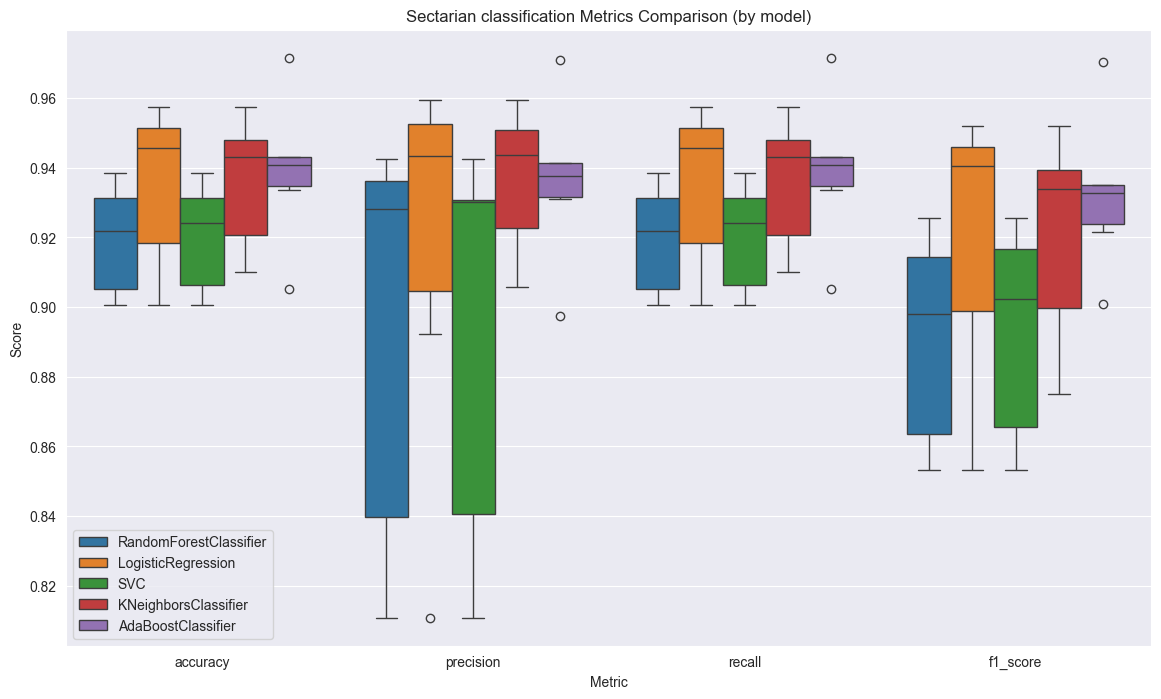

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df_sec.melt(id_vars=['model', 'vectorizer'],
                                      value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                      var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='model', ax=ax)
ax.set_title('Sectarian classification Metrics Comparison (by model)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_model.png")
plt.show()

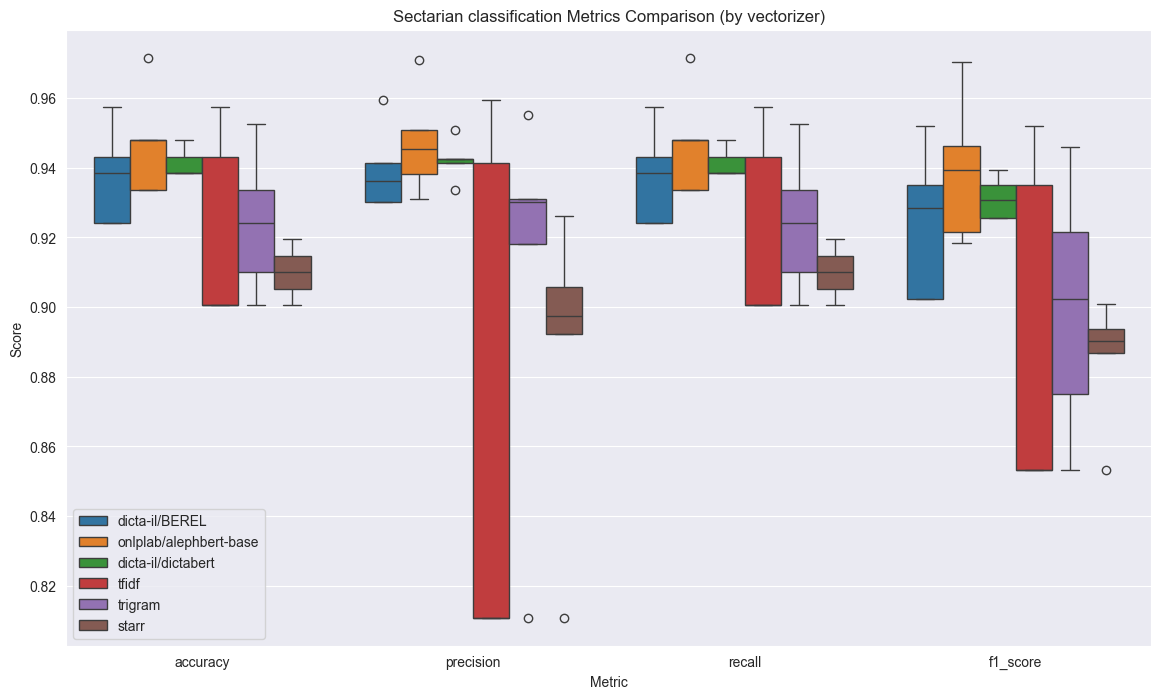

In [16]:

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df_sec.melt(id_vars=['model', 'vectorizer'],
                                      value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                      var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='vectorizer', ax=ax)
ax.set_title('Sectarian classification Metrics Comparison (by vectorizer)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_vectorizer.png")
plt.show()

## Is temple scroll is sectarian?

In [33]:
import numpy as np


def generate_plot_temple_scroll(X_test, y_pred, le, df_sec_all, test_idx):
    # Initialize t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)

    # Fit t-SNE on the vectorized test data
    X_test_embedded = tsne.fit_transform(X_test)

    # Convert y_pred to labels
    predicted_labels = le.inverse_transform(y_pred)

    percent_sectarian = np.mean(predicted_labels == 'sectarian_texts') * 100

    # Create a DataFrame for plotting
    plot_data = {
        'tsne_component_1': X_test_embedded[:, 0],
        'tsne_component_2': X_test_embedded[:, 1],
        'predicted_label': predicted_labels,
        'sentence_path': df_sec_all.loc[test_idx, 'sentence_path']
    }
    plot_df = pd.DataFrame(plot_data)

    # Plot with Plotly
    fig = px.scatter(plot_df, x='tsne_component_1', y='tsne_component_2', color='predicted_label',
                     labels={'tsne_component_1': 't-SNE Component 1', 'tsne_component_2': 't-SNE Component 2'},
                     title=f'Is Temple Scroll is sectarian? (embeddings: {vectorizer_type})\nPercentage of predicted sectarian_texts: {percent_sectarian:.2f}%',
                     hover_data=['predicted_label', "sentence_path"])

    # Show the plot
    return fig


df_sec_all = df
df_sec_all["section"] = df_sec_all["section"].fillna("unknown")
label_column = "section"
train_idx = df_sec_all[df_sec_all["section"] != "unknown"].index
test_idx = df_sec_all[df_sec_all["composition"] == "Temple Scroll"].index

models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=200),
    "SVC": SVC(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
}
best_classifiers_on_temple_scroll_figs = []

best_models = list(metrics_df_sec.groupby(["model"])["f1_score"].mean().index[:3])
best_vectorizers = list(metrics_df_sec.groupby(["vectorizer"])["f1_score"].mean().index[:2])

best_models_vectorizers = metrics_df_sec[
    (metrics_df_sec["model"].isin(best_models)) & (metrics_df_sec["vectorizer"].isin(best_vectorizers))]
for row in best_models_vectorizers.to_dict(orient="records"):
    vectorizer_type = row["vectorizer"]
    model_name = row["model"]
    model = models.get(model_name)

    le = LabelEncoder()
    df_sec_all['encoded_labels'] = le.fit_transform(df_sec_all[label_column])

    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    X_train, y_train = vectorizer_matrix[train_idx], df_sec_all.loc[train_idx, 'encoded_labels']
    X_test, y_test = vectorizer_matrix[test_idx], df_sec_all.loc[test_idx, 'encoded_labels']
    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fig = generate_plot_temple_scroll(X_test, y_pred, le, df_sec_all, test_idx)
    tmp_result = {"fig": fig, "vectorizer": vectorizer_type, "model": model_name}
    best_classifiers_on_temple_scroll_figs.append(tmp_result)

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initializatio

In [34]:

with open(f"{PATH}/is_temple_scroll_is_sec.html", "w") as f:
    for i, fig_data in enumerate(best_classifiers_on_temple_scroll_figs):
        fig = fig_data["fig"]
        vectorizer_type = fig_data["vectorizer"]
        model_name = fig_data["model"]
        html_str = pio.to_html(fig, full_html=False)
        f.write(html_str)
        f.write(
            f"<hr>embeddings: {vectorizer_type}, classifier: {model_name}. trained over all of our sectarian labeled data ({sec_df.shape[0]} samples)<hr>")  # Add a horizontal rule between plots for s


## Supervised classification for composition

In [20]:

# Define the models and vectorizers to be evaluated
models = [
    RandomForestClassifier(random_state=42),
    LogisticRegression(max_iter=200),
    SVC(),
    KNeighborsClassifier(),
    AdaBoostClassifier(random_state=42),
]
metrics_list = []
vectorizer_types = processed_vectorizers_comp.keys()
label_column = "composition"
train_idx, test_idx = train_test_split(
    df_comp.reset_index().index, test_size=0.3, random_state=42, stratify=df_comp.reset_index()[label_column])
# Iterate over each model and vectorizer, compute metrics
for model in tqdm(models, desc="model"):
    for vectorizer_name in tqdm(vectorizer_types, desc="vectorizer"):
        metrics = compute_classification_metrics(model, processed_vectorizers_comp, vectorizer_name,
                                                 df_comp.reset_index(), train_idx, test_idx, label_column)
        metrics['vectorizer'] = vectorizer_name
        metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/composition_classification"
metrics_df.to_csv(f"{PATH}/composition_classification.csv", index=False)
metrics_df.sort_values(by=["f1_score", "accuracy"], ascending=False)
metrics_df



model:   0%|          | 0/5 [00:00<?, ?it/s]

vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: U

vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: 

vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: U

vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: U

vectorizer:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: U

,model,accuracy,precision,recall,f1_score,vectorizer
0,RandomForestClassifier,0.577869,0.508769,0.577869,0.509984,dicta-il/BEREL
1,RandomForestClassifier,0.594262,0.553768,0.594262,0.536243,onlplab/alephbert-base
2,RandomForestClassifier,0.618852,0.570894,0.618852,0.556700,dicta-il/dictabert
3,RandomForestClassifier,0.577869,0.524838,0.577869,0.511155,tfidf
4,RandomForestClassifier,0.598361,0.531630,0.598361,0.539326,trigram
5,RandomForestClassifier,0.463115,0.411093,0.463115,0.412407,starr
6,LogisticRegression,0.737705,0.724538,0.737705,0.722266,dicta-il/BEREL
7,LogisticRegression,0.704918,0.709060,0.704918,0.695285,onlplab/alephbert-base
8,LogisticRegression,0.696721,0.711635,0.696721,0.687486,dicta-il/dictabert
9,LogisticRegression,0.528689,0.444423,0.528689,0.427848,tfidf


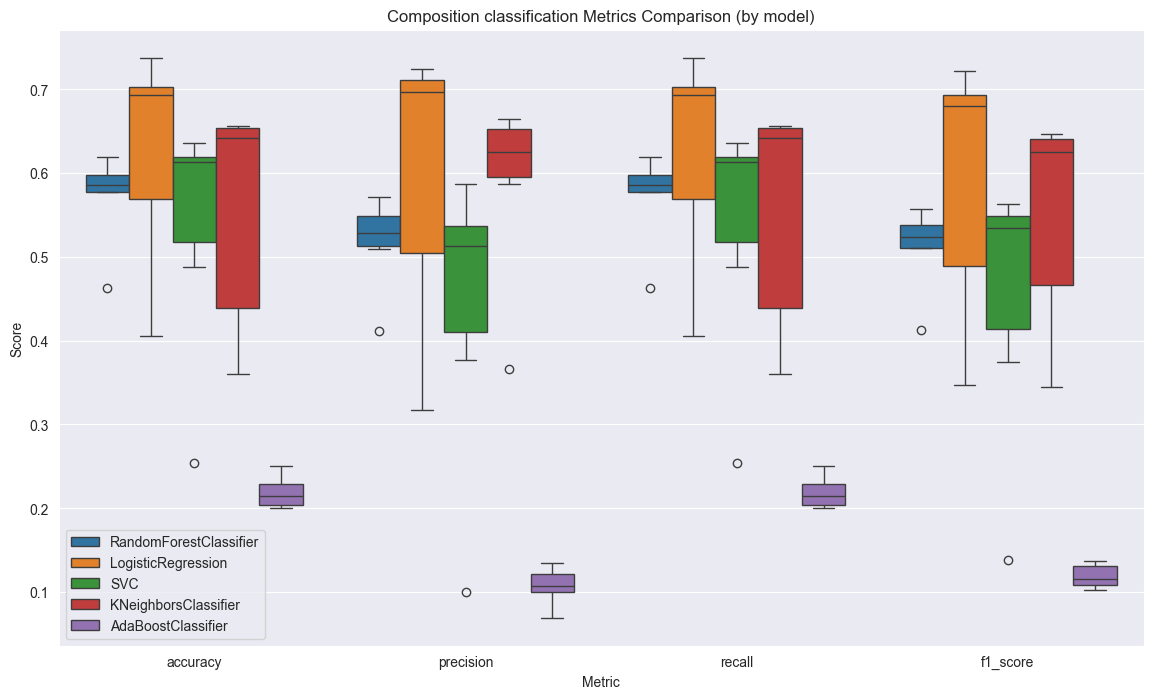

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df.melt(id_vars=['model', 'vectorizer'],
                                  value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                  var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='model', ax=ax)
ax.set_title('Composition classification Metrics Comparison (by model)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_model.png")
plt.show()

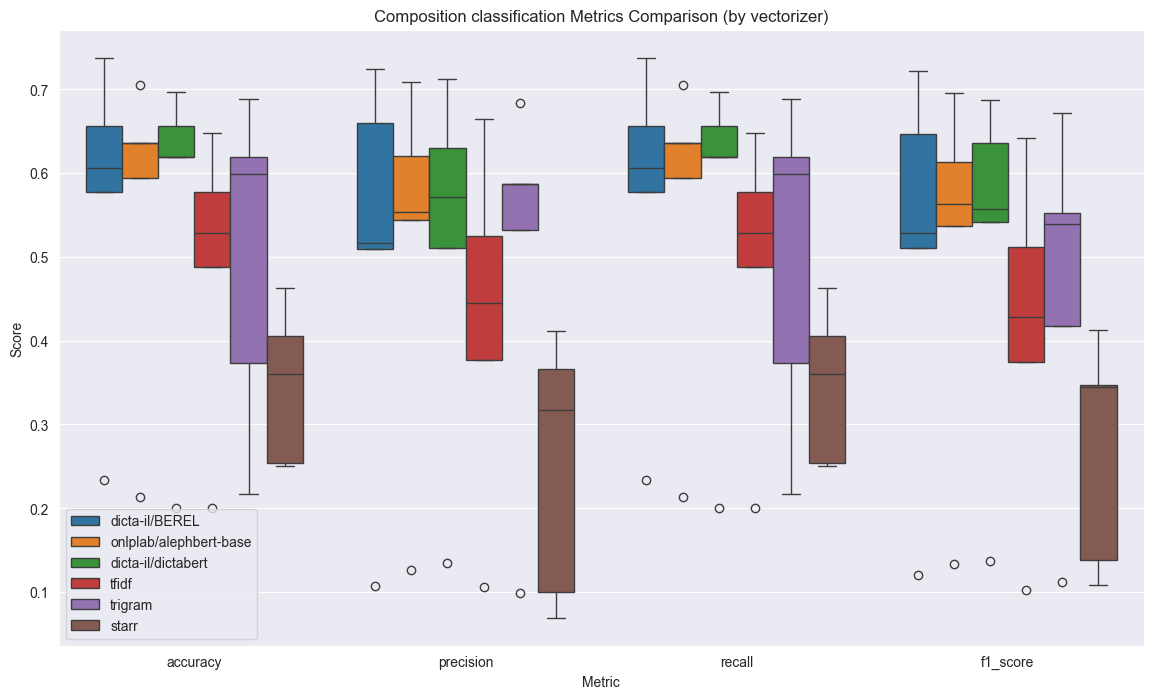

In [22]:

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df.melt(id_vars=['model', 'vectorizer'],
                                  value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                  var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='vectorizer', ax=ax)
ax.set_title('Composition classification Metrics Comparison (by vectorizer)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_vectorizer.png")
plt.show()

In [23]:
df_comp["composition"].nunique()

22

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score,
                             jaccard_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score)
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
from sklearn.model_selection import ParameterGrid
import numpy as np


def get_clusterer(clustering_algo, n_clusters, params):
    if clustering_algo == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, **params)
    elif clustering_algo == 'agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, **params)
    elif clustering_algo == 'dbscan':
        clusterer = DBSCAN(**params)
    elif clustering_algo == 'mean_shift':
        clusterer = MeanShift(**params)
    elif clustering_algo == 'spectral':
        clusterer = SpectralClustering(n_clusters=n_clusters, random_state=42, **params)
    elif clustering_algo == 'birch':
        clusterer = Birch(n_clusters=n_clusters, **params)
    elif clustering_algo == 'gaussian_mixture':
        clusterer = GaussianMixture(n_components=n_clusters, random_state=42, **params)
    else:
        raise ValueError("Unsupported clustering algorithm.")
    return clusterer


def compute_metrics(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo, n_clusters, params):
    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    if vectorizer_matrix is None or vectorizer_matrix.shape[0] == 0:
        return None
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()
    clusterer = get_clusterer(clustering_algo, n_clusters, params)

    if clustering_algo == 'gaussian_mixture':
        predicted_labels = clusterer.fit_predict(vectorizer_matrix)
    else:
        df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(str)
        predicted_labels = clusterer.labels_

    le = LabelEncoder()
    le.fit(df[label_column])
    true_labels_encode = le.transform(df[label_column])

    ari = adjusted_rand_score(true_labels_encode, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels_encode, predicted_labels)
    fmi = fowlkes_mallows_score(true_labels_encode, predicted_labels)
    jaccard = jaccard_score(true_labels_encode, predicted_labels, average="weighted")

    metrics = {
        'vectorizer_type': vectorizer_type,
        'clustering_algo': clustering_algo,
        'params': params,
        'ari': ari,
        'nmi': nmi,
        'fmi': fmi,
        'jaccard': jaccard
    }

    if len(set(predicted_labels)) > 1:
        silhouette = silhouette_score(vectorizer_matrix, predicted_labels)
        calinski_harabasz = calinski_harabasz_score(vectorizer_matrix, predicted_labels)
        davies_bouldin = davies_bouldin_score(vectorizer_matrix, predicted_labels)
        metrics.update({
            'silhouette': silhouette,
            'calinski_harabasz': calinski_harabasz,
            'davies_bouldin': davies_bouldin
        })
    else:
        metrics.update({
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None
        })

    return metrics


def find_best_params(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo, n_clusters, param_grid):
    best_metrics = None
    best_params = None
    best_score = -float('inf')

    for params in ParameterGrid(param_grid):
        # Skip invalid combinations for AgglomerativeClustering
        if clustering_algo == 'agglomerative':
            if params.get('linkage') == 'ward' and params.get('affinity') != 'euclidean':
                continue
            if params.get('affinity') == 'cosine' and np.any(
                    ~np.any(processed_vectorizers.get(vectorizer_type), axis=1)):
                continue

        metrics = compute_metrics(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo, n_clusters,
                                  params)
        if metrics is None:
            continue
        if metrics['ari'] > best_score:
            best_score = metrics['ari']
            best_metrics = metrics
            best_params = params

    return best_metrics


def generate_plots(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo='kmeans', n_clusters=2,
                   params=None):
    simplefilter(action='ignore', category=FutureWarning)
    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()

    clusterer = get_clusterer(clustering_algo, n_clusters, params)
    df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(
        str)  # Convert labels to strings if needed

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(vectorizer_matrix)

    # Add t-SNE results to the dataframe
    df['tsne-2d-one'] = tsne_results[:, 0]
    df['tsne-2d-two'] = tsne_results[:, 1]

    # Create a facet plot to compare true and predicted labels
    df['label_type'] = 'Predicted'
    true_labels_df = df.copy()
    true_labels_df['predicted_cluster'] = true_labels_df[label_column]
    true_labels_df['label_type'] = 'True'
    combined_df = pd.concat([df, true_labels_df])

    facet_fig = px.scatter(
        combined_df, x='tsne-2d-one', y='tsne-2d-two',
        color='predicted_cluster', facet_col='label_type',
        hover_data={'book': True, label_column: True, "sentence_path": True},
        title=f"t-SNE visualization of clusters: Predicted vs. True ({vectorizer_type}, {clustering_algo})"
    )

    # Update the figure size
    facet_fig.update_layout(
        width=1000,  # Adjust the width as needed
        height=800  # Adjust the height as needed
    )

    facet_fig.update_traces(marker=dict(size=10),
                            selector=dict(mode='markers+text'))
    simplefilter(action='default', category=FutureWarning)
    return facet_fig


vectorizer_types = processed_vectorizers_sec.keys()
clustering_algorithms = {
    'kmeans': {
        'init': ['k-means++', 'random'],
        'n_init': [10, 20],
        'max_iter': [300]
    },
    'agglomerative': {
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single']
    },
    'dbscan': {
        'eps': [0.5, 1, 2, 5, 10],
        'min_samples': [5, 10, 20]
    },
    # 'spectral': {
    #     'eigen_solver': [None, 'arpack', 'lobpcg'],
    #     'affinity': ['nearest_neighbors', 'rbf'],
    #     'n_init': [10, 20],
    #     'assign_labels': ['kmeans', 'discretize']
    # },
    'gaussian_mixture': {
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-3, 1e-4],
        'reg_covar': [1e-6, 1e-5],
        'max_iter': [100, 200]
    }
}
metrics_list = []

for vectorizer_type in tqdm(vectorizer_types):
    for clustering_algo, param_grid in tqdm(clustering_algorithms.items()):
        n_clusters = sec_df["section"].nunique() if clustering_algo not in ['dbscan', 'mean_shift'] else None
        best_metrics = find_best_params(processed_vectorizers_sec, vectorizer_type, sec_df, "section", clustering_algo,
                                        n_clusters, param_grid)
        if best_metrics:
            metrics_list.append(best_metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
metrics_df.sort_values(by=["ari", "jaccard"], inplace=True)

TOP = 3
for best_met in metrics_df.sort_values(by="silhouette", ascending=False).to_dict(orient="records")[:TOP]:
    vectorizer_type = best_met["vectorizer_type"]
    clustering_algo = best_met["clustering_algo"]
    params = best_met["params"]
    facet_fig = generate_plots(processed_vectorizers_sec, vectorizer_type, sec_df, "section",
                               clustering_algo=clustering_algo, n_clusters=sec_df["section"].nunique(), params=params)
    facet_fig.show()

## Plot scatter plots

In [14]:

import pandas as pd
from src.plots_generation.analysis_utils import get_gae_embeddings
from src.baselines.embeddings import get_bert_models, VectorizerProcessor
from config import get_paths_by_domain, BASE_DIR
from scipy import  sparse as sp
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import plotly.express as px
from warnings import simplefilter
from scipy import sparse as sp
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, jaccard_score
from sklearn.preprocessing import LabelEncoder
exp_dir = f"{BASE_DIR}/experiments/dss/sectarian_similarities"
DOMAIN = "dss"
paths = get_paths_by_domain("dss")
df_path = paths["data_csv_path"]
df = pd.read_csv(df_path)
vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf", "starr"]
processor = VectorizerProcessor(
    df, paths["processed_vectorizers_path"], vectorizers
)
processed_vectorizers = processor.load_or_generate_embeddings()

bert_model = "dicta-il/BEREL"
model_file = "trained_gae_model_BEREL.pth"
param_dict = {
    "num_adjs": 2,
    "epochs": 50,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.001,
    "threshold": 0.98,
    "adjacencies": [
        {"type": "tfidf", "params": {"max_features": 10000, "min_df": 0.01}},
        {
            "type": "trigram",
            "params": {
                "analyzer": "char",
                "ngram_range": (3, 3),
                "min_df": 0.01,
                "max_features": 10000,
            },
        },
    ],
}
gae_embeddings = get_gae_embeddings(
    df, processed_vectorizers, bert_model, model_file, param_dict
)
def get_clusterer(clustering_algo, n_clusters):
    # Apply the selected clustering algorithm
    if clustering_algo == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    elif clustering_algo == 'agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    elif clustering_algo == 'dbscan':
        clusterer = DBSCAN(eps=6, min_samples=5)
    else:
        raise ValueError("Unsupported clustering algorithm. Choose from 'kmeans', 'agglomerative', or 'dbscan'.")
    return clusterer

def generate_plots(df, embeddings, vectorizer_type, label_column):
    
    if sp.issparse(embeddings):
        embeddings = embeddings.toarray()
    n_clusters = df[label_column].nunique()
    clusterer = get_clusterer("kmeans", n_clusters)
    df['predicted_cluster'] = clusterer.fit_predict(embeddings).astype(
        str)  # Convert labels to strings if needed

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    # Add t-SNE results to the dataframe
    df['tsne-2d-one'] = tsne_results[:, 0]
    df['tsne-2d-two'] = tsne_results[:, 1]

    # Create a facet plot to compare true and predicted labels
    df['label_type'] = 'Predicted'
    true_labels_df = df.copy()
    true_labels_df['predicted_cluster'] = true_labels_df[label_column]
    true_labels_df['label_type'] = 'True'
    combined_df = pd.concat([df, true_labels_df])

    facet_fig = px.scatter(
        combined_df, x='tsne-2d-one', y='tsne-2d-two',
        color='predicted_cluster', facet_col='label_type',
        hover_data={'book': True, label_column: True, "sentence_path": True},
        title=f"t-SNE visualization of clusters: Predicted vs. True ({vectorizer_type})"
    )

    # Update the figure size
    facet_fig.update_layout(
        width=1000,  # Adjust the width as needed
        height=800  # Adjust the height as needed
    )

    facet_fig.update_traces(marker=dict(size=10),
                            selector=dict(mode='markers+text'))
    simplefilter(action='default', category=FutureWarning)
    return facet_fig

for vectorizer_type in vectorizers[:3]:
    embeddings_tmp = processed_vectorizers[vectorizer_type]
    facet_fig = generate_plots(df, embeddings_tmp, vectorizer_type, "composition")
    facet_fig.show()

facet_fig = generate_plots(df, gae_embeddings, "GAE", "composition")
facet_fig.show()

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT'])
2025-02-22 10:26:56.414315 - tfidf n edges before filtering: 851070, n edges after filtering: 19130
2025-02-22 10:26:57.162457 - trigram n edges before filtering: 956484, n edges after filtering: 19130


/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

